In [1]:
import tensorflow as tf

In [198]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.patches import Polygon, Arrow
import itertools
import os 
import albumentations as albu
import cv2

def get_image(index, data, target_size, dataset_directory, normalize = True, transformer = None):

    image = cv2.imread(os.path.join(dataset_directory, data['image_path'].values[index].strip())) #dataset_directory + data['image_path'].values[index])
    labels = np.array([(data['tlx'].values[index], data['tly'].values[index]), (data['trx'].values[index], data['try'].values[index]), (data['brx'].values[index], data['bry'].values[index]), (data['blx'].values[index], data['bly'].values[index])])
    image = cv2.resize(image, target_size)

#     labels[labels>1] = 1
#     labels[labels<0] = 0
#     labels = labels*222

    if transformer is not None:
        try:
            labels = labels*223
            outs = transformer(image = image, keypoints = labels)
            labels = np.array(outs['keypoints'])
            labels = labels/223.0
        except:

            labels = labels/223
#             import pdb;pdb.set_trace()

            labels = labels.reshape(8)
            delta = np.zeros(8)
            delta[labels>1] = labels[labels>1] - 1
            labels[labels>1] = 1
            l2 = labels<0
            delta[labels<0] = - labels[labels<0]
            labels[labels<0] = 0
            labels = labels.reshape((4,2))
            
            labels = labels*223
            delta = delta*223

            try:
                outs = transformer(image = image, keypoints = labels)
            except:
                import pdb;pdb.set_trace()
            
            labels = np.array(outs['keypoints'])
            labels = labels.reshape(8)
            labels[labels == 0] -= delta[labels == 0]
            labels[labels == 223] += delta[labels == 223]
            labels = labels/223.0
            
        image = outs['image']
        
    
    if normalize:
        image = image/255.0
    
    labels = labels.reshape((8))
    return [image, labels]
    

def generator(data, image_wh, batch_size, dataset_directory, normalize = True, transformer = None):
    while True:
        # Randomize the indices to make an array
        indices_arr = np.random.permutation(len(data))
        for batch in range(0, len(indices_arr), batch_size):
            # slice out the current batch according to batch-size
            current_batch = indices_arr[batch:(batch + batch_size)]

            # initializing the arrays, x_train and y_train
            x_train = np.empty([0, image_wh, image_wh, 3], dtype=np.float32)
            y_train = np.empty([0, 8], dtype=np.int32)

            for i in current_batch:
                [image, color] = get_image(i, data, (image_wh, image_wh), dataset_directory, normalize = normalize, transformer = transformer)
                x_train = np.append(x_train, [image], axis=0)
                y_train = np.append(y_train, [color], axis=0)

#                 [image, color] = get_image(i, data, (image_wh, image_wh), dataset_directory, normalize = normalize)
#                 x_train = np.append(x_train, [image], axis=0)
#                 y_train = np.append(y_train, [color], axis=0)


            # y_train = to_categorical(y_train, num_classes=NUM_CLASSES)

            yield (x_train, y_train)

def create_transformer(transformations):
    return albu.Compose(transformations, p=1, keypoint_params=albu.KeypointParams(format='xy'))#(image=image, keypoints=points)


In [199]:
dataset_directory = './card_dataset_test_v4'
image_wh = 224
target_size = (image_wh, image_wh)
# valid_len = len(df) * 3 // 4
seed = 1
batch_size = 16 #@param {type:"integer"}
batch_size_valid = 8
df = pd.read_csv(os.path.join(dataset_directory, 'labels.csv'), header='infer')
df.drop(columns=['glare'], inplace=True)
labels = list(df)[1:]
filenames = list(df)[0]
train_len = len(df) // 2
trainDF = df
steps_per_epoch = len(df) // batch_size
transformer = create_transformer([
                                  albu.VerticalFlip(p=.5), 
                                  albu.HorizontalFlip(p=0.5),
                                  albu.Flip(p=0.5),
                                  albu.OneOf([albu.HueSaturationValue(p=0.5), albu.RGBShift(p=0.7)], p=1),
                                  albu.RandomBrightnessContrast(p=0.5)
                                  ])

In [200]:
train_generator = generator(trainDF, image_wh, batch_size, dataset_directory, transformer = transformer)


In [201]:
x, y = next(train_generator)

In [202]:
def vis_points(image, points, diameter=3):
    im = image.copy()
    points = points.reshape((4, 2))

    for (x, y) in points:
#     draw = points[0]
#     print(draw)
#     x, y = draw
        cv2.circle(im, (int(x), int(y)), diameter, (0, 255, 0), -1)

    plt.imshow(im)
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 24.408384 238.941808 204.186976 152.14864  153.730304  38.26144
 -34.77488  126.16128 ] 0


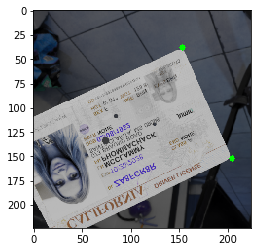

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 24.408384 -14.941808 204.186976  71.85136  153.730304 185.73856
 -34.77488   97.83872 ] 1


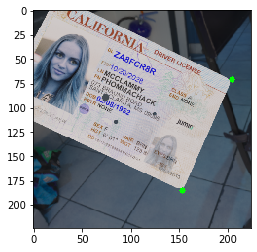

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 34.715968  86.70704  200.617984 182.2128   268.21088   67.115776
  87.030944 -17.21664 ] 2


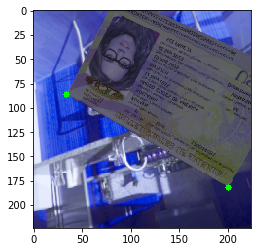

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 34.715968 137.29296  200.617984  41.7872   268.21088  156.884224
  87.030944 241.21664 ] 3


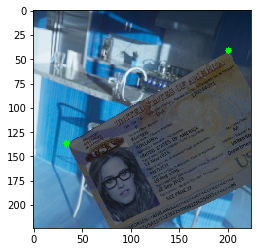

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[208.7503712 171.619168   11.513152  217.0861728  -6.76704    94.140032
 177.43936    56.994336 ] 4


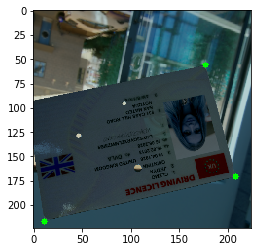

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 15.2496288  52.380832  212.486848    6.9138272 230.76704   129.859968
  46.56064   167.005664 ] 5


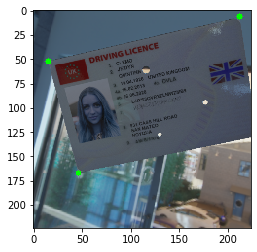

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[142.139648  28.549696   3.805536  91.98      47.143712 179.076576
 181.375712 111.882624] 6


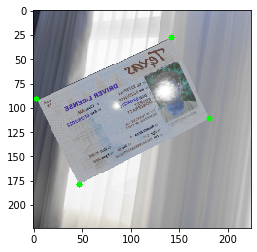

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 81.860352  28.549696 220.194464  91.98     176.856288 179.076576
  42.624288 111.882624] 7


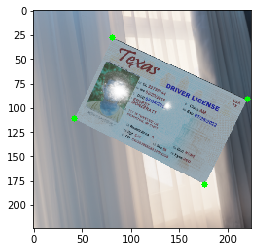

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 46.864832   41.378624  194.793312   80.736544  175.007168  172.3176
  22.3436192 138.97632  ] 8


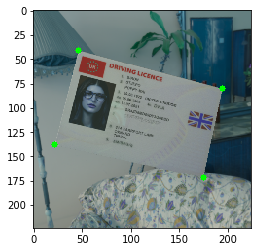

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 46.864832   41.378624  194.793312   80.736544  175.007168  172.3176
  22.3436192 138.97632  ] 9


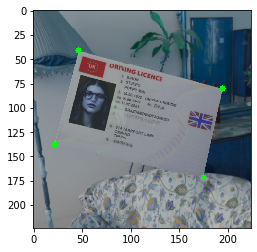

In [203]:
i = 0
for i in range(10):
    xo, yo = x[i], y[i]
    print(yo*224, i)
    vis_points(xo, yo*224)